<a href="https://colab.research.google.com/github/rahul-palnitkar/ODSC-25/blob/main/notebooks/00_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Bayesian Sampling

This notebook is part of a tutorial on "Practical Bayesian Modeling with PyMC"

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurveyDataPyMC/blob/main/notebooks/00_intro.ipynb)

In [ ]:
# Get utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/SurveyDataPyMC/raw/main/notebooks/utils.py")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

from utils import value_counts, decorate, plot_prior

In [ ]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## PyMC is a RNG

Suppose we ask 1000 people to flip a coin and report the result.
In this case, we know the probability is 0.5, and we can generate a synthetic sample like this.

In [29]:
# Fill this in

with pm.Model() as model:
    p = 0.5
    y = pm.Bernoulli("y", p=p)

In [30]:
with model:
    idata = pm.sample_prior_predictive(draws=1000)

In [31]:
idata.prior['y'].mean()

<xarray.DataArray 'y' ()> Size: 8B
array(0.481)

In [32]:
y_data = idata.prior['y'].to_numpy()

## Uncertain p

Now suppose we ask 1000 people to answer a factual question.
We imagine that some people are more likely than others to get it right, so we can let the probability of success vary.

In [ ]:
# Modify this

with pm.Model() as model:
    p = 0.5
    y = pm.Bernoulli("y", p=p)

In [ ]:
with model:
    idata = pm.sample_prior_predictive(draws=1000)

In [ ]:
plot_prior(idata)
decorate()

## Latent propensity

Now suppose we ask 1000 people if they are happy.
We can imagine that each person has a latent happiness factor, which influences their tendency to say they are happy.

Specifically, we'll assume the distribution of the factor is Normal, and use the sigmoid function (aka expit, aka inverse logit) to map from log odds to probability.

In [34]:
# Modify this

with pm.Model() as model:
    z = pm.Normal("z", mu=0, sigma=1)
    p = pm.math.sigmoid(z)
    y = pm.Bernoulli("y", p=p)

In [35]:
with model:
    idata = pm.sample_prior_predictive(draws=1000)

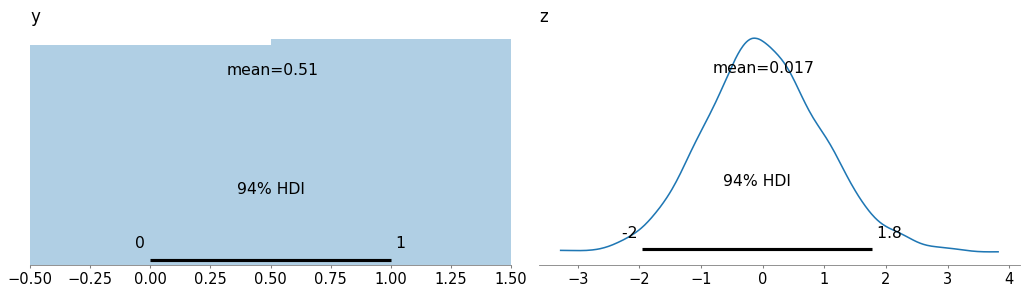

In [36]:
plot_prior(idata)
decorate()

Let's save the result from this model and suppose it's actual data we collected in a survey.

In [37]:
y_data = idata.prior['y'].to_numpy()

In [38]:
from scipy.special import logit

ref_val = logit(y_data.mean())
ref_val

np.float64(0.028001829548493083)

## Observed data

Now we'll use the same model, but now instead of generating `y`, we treat `y` as an observed variable.

Instead of `sample_prior_predictive`, which uses known parameters of the model to generate data, we'll use `sample`, which uses the data to infer the parameters of the model.

In [40]:
# Modify this

with pm.Model() as model:
    z = pm.Normal("z", mu=0, sigma=1)
    p = pm.math.sigmoid(z)
    y = pm.Bernoulli("y", p=p, observed=y_data)

In [41]:
with model:
    idata = pm.sample(draws=1000)

Output()

Now the posterior distribution represents what we believe about the `z` after seeing the data.

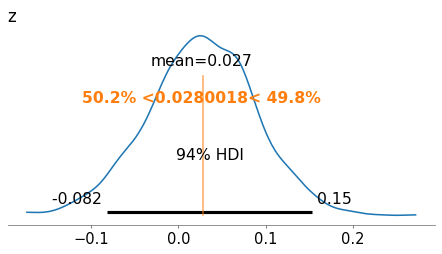

In [42]:
az.plot_posterior(idata, ref_val=ref_val)
decorate()